## Theory

In this lab work I reproduce experiments from article "Learning to learn by gradient descent by gradient descent".

Code based on [github](https://github.com/teddykoker/learning-to-learn-jax) and [jax tutorial](https://jax.readthedocs.io/en/latest/notebooks/neural_network_with_tfds_data.html#data-loading-with-tensorflow-datasets).

Frequently, tasks in machine learning can be expressed as the problem of optimizing an objective function $f(\theta)$ defined over some domain $\theta \in \Theta$.  The goal in this case is to find the minimizer
$\theta^* = \underset{\theta \in \Theta}{\operatorname{argmin}} f(\theta)$ While any method capable of minimizing this objective function can be applied, the standard approach for differentiable functions is some form of gradient descent, resulting in a sequence of updates $$ \theta_{t+1} = \theta_t - \alpha \nabla f(\theta_t).$$




In this work authors take a different tack and instead propose to replace hand-designed update rules with a learned update rule, which they call the optimizer $g$, specified by its own set of parameters $\phi$. This results in updates to the optimizee $f$ of the form $$\theta_{t+1} = \theta_t + g_t(\nabla f(\theta_t), \phi).$$

In experiments loss function for optimizer $$ \mathcal{L}(\phi) = E_f \sum_{i=1}^T f(\theta_i),$$ where $\{\theta_i\}_{i=1}^T$ is trajectory under optimization.

## Imports

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
import tensorflow as tf
import tensorflow_datasets as tfds

from jax import random
from jax import vmap
from jax.scipy.special import logsumexp
from flax import serialization
from flax import linen as nn
from functools import partial
from tqdm import tqdm


## The Task: Quadratic Function

In [2]:
def quadratic_data(rng):
    batch_size=128
    dim=10
    keys = jax.random.split(rng, 2)
    w = jax.random.normal(keys[0], (batch_size, dim, dim))
    y = jax.random.normal(keys[1], (batch_size, dim))
    return w, y

def quadratic_theta(rng):
    batch_size = 128
    dim = 10
    theta = jax.random.normal(rng, (batch_size, dim))
    return theta

def quadratic_task(w, y, theta, opt_fn, opt_state, steps=100):
    @jax.jit
    def f(theta):
        product = vmap(jnp.matmul)(w, theta)
        return jnp.mean(jnp.sum((product - y) ** 2, axis=1))

    losses = []
    for _ in range(steps):
        loss, grads = jax.value_and_grad(f)(theta)
        updates, opt_state = opt_fn(grads, opt_state)
        theta += updates
        losses.append(loss)

    return jnp.stack(losses), theta, opt_state

## Create and train LSTM

In [3]:
class LSTMOptimizer(nn.Module):
    hidden_units: int = 20

    def setup(self):
        self.lstm1 = nn.recurrent.LSTMCell()
        self.lstm2 = nn.recurrent.LSTMCell()
        self.fc = nn.Dense(1)

    def __call__(self, gradient, state):
        # gradients of optimizee do not depend on optimizer
        gradient = jax.lax.stop_gradient(gradient)

        # expand parameter dimension to extra batch dimension so that network
        # is "coodinatewise"
        gradient = gradient[..., None]

        carry1, carry2 = state
        carry1, x = self.lstm1(carry1, gradient)
        carry2, x = self.lstm2(carry2, x)
        update = self.fc(x)
        update = update[..., 0]  # remove last dimension
        return update, (carry1, carry2)

    def initialize_carry(self, rng, params):
        return (
            nn.LSTMCell.initialize_carry(rng, params.shape, self.hidden_units),
            nn.LSTMCell.initialize_carry(rng, params.shape, self.hidden_units),
        )

In [4]:
def train(data_fn, task_fn, theta_init, args):

    rng = jax.random.PRNGKey(seed=args["seed"])

    example_input = jnp.zeros((args["batch_size"], args["dim"]))
    lstm_opt = LSTMOptimizer()
    lstm_state = lstm_opt.initialize_carry(rng, example_input)
    params = lstm_opt.init(rng, example_input, lstm_state)

    meta_opt = optax.adam(learning_rate=args["learning_rate"])
    meta_opt_state = meta_opt.init(params)

    @jax.jit
    def train_step(params, w, y, theta, state):
        def loss_fn(params):
            update = partial(lstm_opt.apply, params)
            losses, _theta, _state = task_fn(
                w, y, theta, update, state, args["unroll_steps"]
            )
            return losses.sum(), (_theta, _state)

        (loss, (_theta, _state)), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)
        return loss, grads, _theta, _state

    best_loss = jnp.inf

    tqdm_range = tqdm(range(args["steps"]))
    for _ in tqdm_range:
        rng, subkey = jax.random.split(rng)
        theta = theta_init(subkey)
        w, y = data_fn(subkey)
        lstm_state = lstm_opt.initialize_carry(rng, theta)
        meta_loss = 0.0

        for _ in range(args["unrolls"]):
            loss, grads, theta, lstm_state = train_step(params, w, y, theta, lstm_state)
            updates, meta_opt_state = meta_opt.update(grads, meta_opt_state)
            params = optax.apply_updates(params, updates)
            meta_loss += loss

        if meta_loss < best_loss:
            best_loss = meta_loss
            with open(args["model_path"], "wb") as f:
                f.write(serialization.to_bytes(params))

        tqdm_range.set_postfix({"loss": meta_loss})

args = {
    "seed": 0, 
    "batch_size": 128,
    "dim": 10,
    "unroll_steps": 20,
    "unrolls": 5,
    "learning_rate": 1e-2,
    "steps": 1000,
    "model_path": "params.mp"
}

train(quadratic_data, quadratic_task, quadratic_theta, args)

100%|██████████| 1000/1000 [07:00<00:00,  2.38it/s, loss=236.24963]


## Results

In [7]:
HAND_OPTIMIZERS = {
    "sgd": optax.sgd,
    "adam": optax.adam,
    "rmsprop": partial(optax.rmsprop),
    "nag": partial(optax.sgd, momentum=0.9, nesterov=True),
}

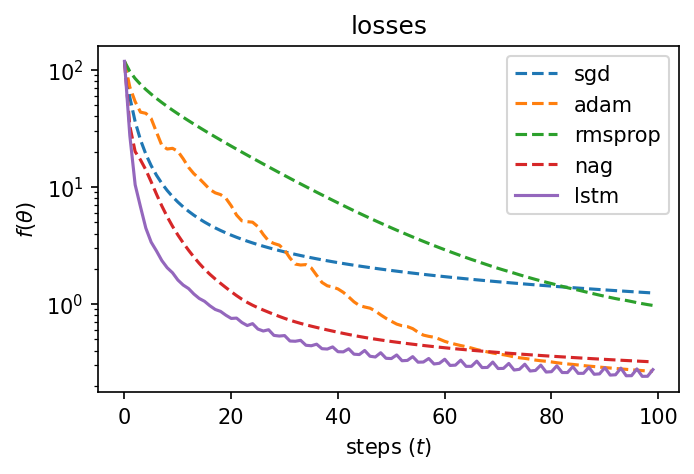

In [10]:
def eval_(data_fn, task_fn, theta_init, args):
    
    rng = jax.random.PRNGKey(args["seed"])
    theta = theta_init(rng)
    w, y = data_fn(rng)

    plt.figure(dpi=150, figsize=(5, 3))

    for name, optimizer in HAND_OPTIMIZERS.items():
        best_losses = None
        for learning_rate in jnp.logspace(-2, 1, num=7):
            opt = optimizer(learning_rate=learning_rate)
            opt_state = opt.init(theta)
            losses, *_ = task_fn(w, y, theta, opt_state=opt_state, opt_fn=opt.update)

            if best_losses is None or losses[-1] < best_losses[-1]:
                best_losses = losses
                # print(f"{name}, best lr: {learning_rate:.0e}")

        plt.plot(best_losses, label=name, linestyle="--")

    lstm_opt = LSTMOptimizer()
    lstm_state = lstm_opt.initialize_carry(rng, theta)
    params = lstm_opt.init(rng, theta, lstm_state)

    with open(args["model_path"], "rb") as f:
        params = serialization.from_bytes(params, f.read())

    update = partial(lstm_opt.apply, params)
    losses, *_ = task_fn(w, y, theta, opt_state=lstm_state, opt_fn=update)
    plt.plot(losses, label="lstm")

    plt.legend()
    plt.title("losses")
    plt.xlabel("steps ($t$)")
    plt.ylabel("$f(\\theta)$")
    plt.yscale("log")

eval_(quadratic_data, quadratic_task, quadratic_theta, args)

## MNIST

### Load data

In [7]:
def one_hot(x, k, dtype=jnp.float32):
  """Create a one-hot encoding of x of size k."""
  return jnp.array(x[:, None] == jnp.arange(k), dtype)

In [8]:
data_dir = '/tmp/tfds'

# Fetch full datasets for evaluation
# tfds.load returns tf.Tensors (or tf.data.Datasets if batch_size != -1)
# You can convert them to NumPy arrays (or iterables of NumPy arrays) with tfds.dataset_as_numpy
mnist_data, info = tfds.load(name="mnist", batch_size=-1, data_dir=data_dir, with_info=True)
mnist_data = tfds.as_numpy(mnist_data)
train_data, test_data = mnist_data['train'], mnist_data['test']
num_labels = info.features['label'].num_classes
h, w, c = info.features['image'].shape
num_pixels = h * w * c

# Full train set
train_images, train_labels = train_data['image'], train_data['label']
train_images = jnp.reshape(train_images, (len(train_images), num_pixels))
train_labels = one_hot(train_labels, num_labels)

# Full test set
test_images, test_labels = test_data['image'], test_data['label']
test_images = jnp.reshape(test_images, (len(test_images), num_pixels))
test_labels = one_hot(test_labels, num_labels)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /tmp/tfds/mnist/3.0.1. Subsequent calls will reuse this data.


In [9]:
print('Train:', train_images.shape, train_labels.shape)
print('Test:', test_images.shape, test_labels.shape)

Train: (60000, 784) (60000, 10)
Test: (10000, 784) (10000, 10)


### Create model

In [13]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
  w_key, b_key = random.split(key)
  return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(key, sizes):
  keys = random.split(key, len(sizes))
  return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

# layer_sizes = [784, 20, 10]
# step_size = 0.01
# num_epochs = 10
# batch_size = 128
# n_targets = 10
# params = init_network_params(layer_sizes, random.PRNGKey(0))

In [14]:
def mnist_data(rng):
    batch_size = 128
    indices = random.randint(rng, shape=(batch_size,), minval=0, maxval=train_images.shape[0])
    X = train_images[indices]
    y = train_labels[indices]
    return X, y

def mnist_theta(rng):
    return init_network_params(rng, [784, 20, 10])

def mnist_task(image, y, theta, opt_fn, opt_state, steps=100):
    def relu(x):
        return jnp.maximum(0, x)

    def f_(theta):
        # per-example predictions
        activations = image
        for w, b in theta[:-1]:
          outputs = jnp.dot(w, activations) + b
          activations = relu(outputs)
        
        final_w, final_b = theta[-1]
        logits = jnp.dot(final_w, activations) + final_b
        return logits - logsumexp(logits)
        
    @jax.jit
    def f(theta):
        # product = vmap(f_)(theta)
        product = vmap(f_, in_axes=(None, 0))(theta)
        return -jnp.mean(product * y)

    losses = []
    for _ in range(steps):
        loss, grads = jax.value_and_grad(f)(theta)
        updates, opt_state = opt_fn(grads, opt_state)
        theta += updates
        losses.append(loss)

    return jnp.stack(losses), theta, opt_state

In [ ]:
args = {
    "seed": 0, 
    "batch_size": 128,
    "dim": 10,
    "unroll_steps": 20,
    "unrolls": 5,
    "learning_rate": 1e-2,
    "steps": 1000,
    "model_path": "params.mp"
}

train(mnist_data, mnist_task, mnist_theta, args)

In [ ]:
eval_(mnist_data, mnist_task, mnist_theta, args)